In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
num_classes = 2
input_shape = (72, 72, 3)
# Define your dataset path
dataset_path = "/kaggle/input/labeledhpcd/hpcd/training"


# Function to load and preprocess images from subfolders
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, class_folder in enumerate(os.listdir(folder)):
        class_path = os.path.join(folder, class_folder)
        for filename in os.listdir(class_path):
            img = cv2.imread(os.path.join(class_path, filename))
            if img is not None:
                img = cv2.resize(img, (72, 72))  # Resize images to match input_shape
                images.append(img)
                labels.append(label)
    return images, labels

x_train, y_train = load_images_from_folder(dataset_path)
x_train = np.array(x_train)
y_train = np.array(y_train)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [3]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [5]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


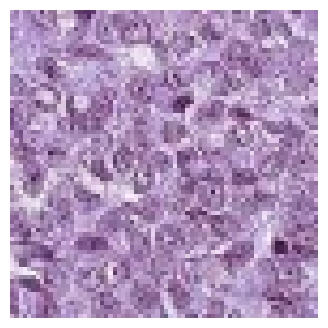

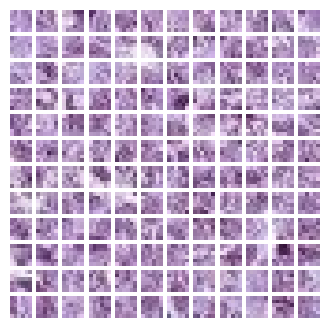

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [11]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [12]:
vit = create_vit_classifier()
vit.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 72, 72, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 72, 72, 3)            7         ['input_2[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_2 (Patches)         (None, None, 108)            0         ['data_augmentation[1][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 144, 64)              16192     ['patches_2[0][0]']       

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
import tensorflow_addons as tfa


def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "ViT_Save"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback]  # Add the checkpoint callback to save weights
    )

    # Save the entire model (architecture + weights)
    model.save("ViT_Save/trained_model")

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/5
392/392 [==============================] - 108s 246ms/step - loss: 0.6061 - accuracy: 0.7707 - top-5-accuracy: 1.0000 - val_loss: 0.5372 - val_accuracy: 0.7354 - val_top-5-accuracy: 1.0000
Epoch 2/5
392/392 [==============================] - 95s 242ms/step - loss: 0.3790 - accuracy: 0.8335 - top-5-accuracy: 1.0000 - val_loss: 0.4015 - val_accuracy: 0.8173 - val_top-5-accuracy: 1.0000
Epoch 3/5
392/392 [==============================] - 94s 239ms/step - loss: 0.3516 - accuracy: 0.8498 - top-5-accuracy: 1.0000 - val_loss: 0.4813 - val_accuracy: 0.7632 - val_top-5-accuracy: 1.0000
Epoch 4/5
392/392 [==============================] - 94s 239ms/step - loss: 0.3321 - accuracy: 0.8609 - top-5-accuracy: 1.0000 - val_loss: 0.4018 - val_accuracy: 0.8148 - val_top-5-accuracy: 1.0000
Epoch 5/5
870/870 [==============================] - 16s 19ms/step - loss: 0.3525 - accuracy: 0.8423 - top-5-accuracy: 1.0000
Test accuracy: 84.23%
Test top 5 accuracy: 100.0%


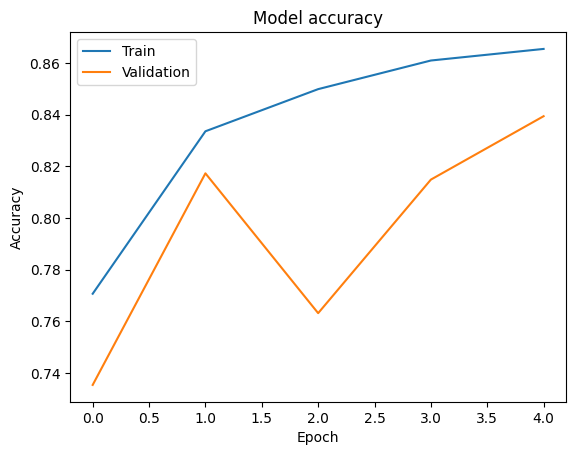

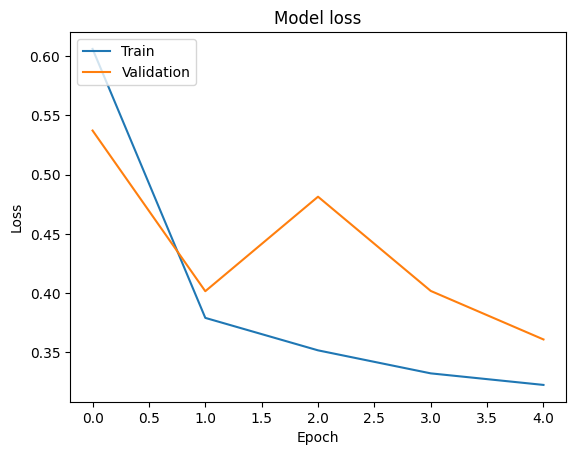

In [14]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
plot_training_history(history)    

In [17]:
from keras.models import load_model

# Load your custom model
new_model = load_model('/kaggle/input/vit-save/ViT_Save/trained_model')

In [ ]:
new_model.evaluate(x_test,y_test)

In [ ]:
# model.predict(x_test)

In [ ]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# # Load your custom model
# model = load_model('ViT_Save/trained_model')

# Assuming x_test is a single test data and y_test is the corresponding label
index = 2  # Choose the index of the test sample you want to visualize
single_test_data = x_test[index]
true_label = y_test[index]

# Preprocess the single test data
processed_test_data = cv2.resize(single_test_data, (72, 72))  # Resize to match input_shape
processed_test_data = np.expand_dims(processed_test_data, axis=0)  # Add batch dimension

# Make prediction
predictions = new_model.predict(processed_test_data)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Visualize the test sample and its prediction
plt.imshow(single_test_data)
plt.title(f'True label: {true_label}, Predicted label: {predicted_class}')
plt.show()

870/870 [==============================] - 18s 19ms/step


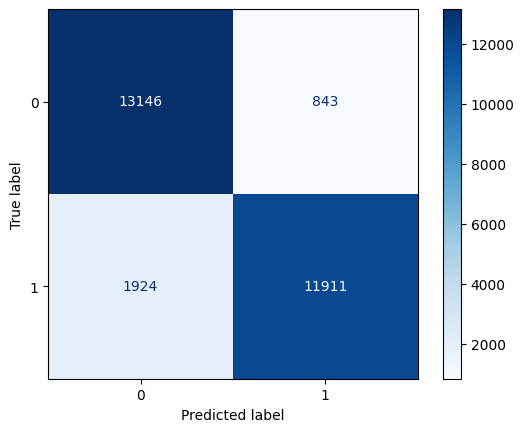

In [19]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming x_test is the set of test data and y_test is the corresponding labels
all_test_data = x_test
all_true_labels = y_test

# # Load your custom model
# model = load_model('ViT_Save/trained_model')

# Create an empty list to store predicted labels
all_predicted_labels = []

# Resize and preprocess the entire batch of test data
processed_test_data = np.array([cv2.resize(img, (72, 72)) for img in all_test_data])

# Make predictions for the entire batch
predictions = new_model.predict(processed_test_data)

# Get the predicted classes for each sample in the batch
all_predicted_labels = np.argmax(predictions, axis=1)

# Convert the lists to NumPy arrays
all_true_labels = np.array(all_true_labels)

# Create the confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(all_true_labels))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()
